<a href="https://colab.research.google.com/github/nikiiny/Market-Basket-Analysis-in-a-distributed-environment-AFMD-project/blob/main/AFMD_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALGORITHMS FOR MASSIVE DATASETS - PROJECT
### MARKET-BASKET ANALYSIS FOR THE IMDB DATASET
https://docs.google.com/document/d/1LvUHa5uqJoalAOUnE3MkhMUF47-5aWDR-biRbHBRprM/edit

The task is to implement a system finding frequent itemsets (aka market-basket analysis), analyzing one of the two datasets described below. <br>
The «IMDB» dataset is published on Kaggle, under IMDb non-commercial licensing. The analysis must be done considering movies as baskets and actors as items.


Set the spark session and spark context

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [3]:
import findspark
findspark.init("spark-3.1.1-bin-hadoop2.7")

from pyspark.sql import SparkSession
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
sc = spark.sparkContext

In [4]:
from pyspark.sql.functions import col, size, collect_set
import pyspark.sql.functions as F
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
import pickle
from tqdm.auto import tqdm
import time
import itertools
from collections import defaultdict
import functools
import operator
from pyspark.ml.fpm import FPGrowth
import time
from collections import defaultdict
from google.colab import drive, files
import os

# DATA DOWNLOAD
Download IMDB dataset from Kaggle through Kaggle API

In [ ]:
!pip install -q kaggle
uploaded = files.upload() #to upload kaggle.json api

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!ls ~/.kaggle

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list &> /dev/null

kaggle.json


In [ ]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

 99% 1.42G/1.44G [00:12<00:00, 77.9MB/s]
100% 1.44G/1.44G [00:12<00:00, 126MB/s] 


Create a directory where the dataset is downloaded and remove the useless folders

In [ ]:
! mkdir -p dataset 
! unzip imdb-dataset.zip -d dataset &> /dev/null

# DATA PRE-PROCESSING


In [ ]:
actors = spark.read.csv("/content/dataset/name.basics.tsv/name.basics.tsv", header=True, inferSchema=True,sep=r'\t')
actors.show(10, False) 

+---------+---------------+---------+---------+------------------------------+---------------------------------------+
|nconst   |primaryName    |birthYear|deathYear|primaryProfession             |knownForTitles                         |
+---------+---------------+---------+---------+------------------------------+---------------------------------------+
|nm0000001|Fred Astaire   |1899     |1987     |soundtrack,actor,miscellaneous|tt0050419,tt0053137,tt0072308,tt0043044|
|nm0000002|Lauren Bacall  |1924     |2014     |actress,soundtrack            |tt0071877,tt0117057,tt0038355,tt0037382|
|nm0000003|Brigitte Bardot|1934     |\N       |actress,soundtrack,producer   |tt0054452,tt0049189,tt0059956,tt0057345|
|nm0000004|John Belushi   |1949     |1982     |actor,writer,soundtrack       |tt0077975,tt0072562,tt0080455,tt0078723|
|nm0000005|Ingmar Bergman |1918     |2007     |writer,director,actor         |tt0069467,tt0050976,tt0083922,tt0050986|
|nm0000006|Ingrid Bergman |1915     |1982     |a

In [ ]:
# Remove missing values

actors = ( actors
          .select(col('nconst').alias('actor_id'), col('primaryName'), col('primaryProfession') )
          .where( (col('actor_id').isNotNull()) & (col('primaryName').isNotNull()) ) 
          .filter( (col('actor_id') != '\\N') | (col('primaryName') != '\\N') )
          )

In [ ]:
# Select only crew members which are also actors

actors.createOrReplaceTempView('actors')

query = """
  SELECT *
  FROM actors
  WHERE (primaryProfession LIKE '%actor%') OR
        (primaryProfession LIKE '%actress%')
"""
actors = spark.sql(query)
actors.show(10, False) 

+---------+---------------+------------------------------+
|actor_id |primaryName    |primaryProfession             |
+---------+---------------+------------------------------+
|nm0000001|Fred Astaire   |soundtrack,actor,miscellaneous|
|nm0000002|Lauren Bacall  |actress,soundtrack            |
|nm0000003|Brigitte Bardot|actress,soundtrack,producer   |
|nm0000004|John Belushi   |actor,writer,soundtrack       |
|nm0000005|Ingmar Bergman |writer,director,actor         |
|nm0000006|Ingrid Bergman |actress,soundtrack,producer   |
|nm0000007|Humphrey Bogart|actor,soundtrack,producer     |
|nm0000008|Marlon Brando  |actor,soundtrack,director     |
|nm0000009|Richard Burton |actor,producer,soundtrack     |
|nm0000010|James Cagney   |actor,soundtrack,director     |
+---------+---------------+------------------------------+
only showing top 10 rows



In [ ]:
print('Number of actors:', actors.count())

Number of actors: 9706922


In [ ]:
movies_to_actors = spark.read.csv('/content/dataset/title.principals.tsv/title.principals.tsv',header=True, inferSchema=True, sep='\t')
movies_to_actors.show(10, False)

+---------+--------+---------+---------------+-----------------------+-----------+
|tconst   |ordering|nconst   |category       |job                    |characters |
+---------+--------+---------+---------------+-----------------------+-----------+
|tt0000001|1       |nm1588970|self           |\N                     |["Herself"]|
|tt0000001|2       |nm0005690|director       |\N                     |\N         |
|tt0000001|3       |nm0374658|cinematographer|director of photography|\N         |
|tt0000002|1       |nm0721526|director       |\N                     |\N         |
|tt0000002|2       |nm1335271|composer       |\N                     |\N         |
|tt0000003|1       |nm0721526|director       |\N                     |\N         |
|tt0000003|2       |nm5442194|producer       |producer               |\N         |
|tt0000003|3       |nm1335271|composer       |\N                     |\N         |
|tt0000003|4       |nm5442200|editor         |\N                     |\N         |
|tt0

In [ ]:
# Remove missing values
movies_to_actors = ( movies_to_actors
          .select(col('tconst').alias('movie_id'), col('nconst').alias('actor_id'), col('category'), col('job') )
          .where( (col('movie_id').isNotNull()) & (col('actor_id').isNotNull()) ) 
          .filter( (col('movie_id') != '\\N') | (col('actor_id') != '\\N'))
          )

Both tables actor and movies_to_actors contain information about the profession of the crew member. It can be possible that in one table the profession is missing while in the other table is present, so we retrieve all the crew members which are categorised as actors in at least one of the 2 tables.

In [ ]:
# Select only crew members which are also actors

movies_to_actors.createOrReplaceTempView('movies_to_actors')
query = """
  SELECT *
  FROM movies_to_actors
  WHERE (category LIKE '%actor%') OR
        (category LIKE '%actress%') OR
        (job LIKE '%actor%') OR
        (job LIKE '%actress%')
"""
movies_to_actors = spark.sql(query)
movies_to_actors.show(10, False) 

+---------+---------+--------+---+
|movie_id |actor_id |category|job|
+---------+---------+--------+---+
|tt0000005|nm0443482|actor   |\N |
|tt0000005|nm0653042|actor   |\N |
|tt0000007|nm0179163|actor   |\N |
|tt0000007|nm0183947|actor   |\N |
|tt0000008|nm0653028|actor   |\N |
|tt0000009|nm0063086|actress |\N |
|tt0000009|nm0183823|actor   |\N |
|tt0000009|nm1309758|actor   |\N |
|tt0000011|nm3692297|actor   |\N |
|tt0000014|nm0166380|actor   |\N |
+---------+---------+--------+---+
only showing top 10 rows



In [ ]:
print('Number of correspondences:', movies_to_actors.count())

Number of correspondences: 14818830


In [ ]:
movies = spark.read.csv('/content/dataset/title.basics.tsv/title.basics.tsv',header=True, inferSchema=True, sep='\t')
movies.show(10, False) 

+---------+---------+-------------------------------------------+-------------------------------------------+-------+---------+-------+--------------+------------------------+
|tconst   |titleType|primaryTitle                               |originalTitle                              |isAdult|startYear|endYear|runtimeMinutes|genres                  |
+---------+---------+-------------------------------------------+-------------------------------------------+-------+---------+-------+--------------+------------------------+
|tt0000001|short    |Carmencita                                 |Carmencita                                 |0      |1894     |\N     |1             |Documentary,Short       |
|tt0000002|short    |Le clown et ses chiens                     |Le clown et ses chiens                     |0      |1892     |\N     |5             |Animation,Short         |
|tt0000003|short    |Pauvre Pierrot                             |Pauvre Pierrot                             |0      |189

In [ ]:
# Remove missing values

movies = ( movies
          .select(col('tconst').alias('movie_id'), col('primaryTitle'), col('genres') )
          .where( (col('movie_id').isNotNull()) & (col('primaryTitle').isNotNull()) ) 
          .filter( (col('movie_id') != '\\N') | (col('primaryTitle') != '\\N'))
          )
movies.show(10, False)

+---------+-------------------------------------------+------------------------+
|movie_id |primaryTitle                               |genres                  |
+---------+-------------------------------------------+------------------------+
|tt0000001|Carmencita                                 |Documentary,Short       |
|tt0000002|Le clown et ses chiens                     |Animation,Short         |
|tt0000003|Pauvre Pierrot                             |Animation,Comedy,Romance|
|tt0000004|Un bon bock                                |Animation,Short         |
|tt0000005|Blacksmith Scene                           |Comedy,Short            |
|tt0000006|Chinese Opium Den                          |Short                   |
|tt0000007|Corbett and Courtney Before the Kinetograph|Short,Sport             |
|tt0000008|Edison Kinetoscopic Record of a Sneeze     |Documentary,Short       |
|tt0000009|Miss Jerry                                 |Romance                 |
|tt0000010|Exiting the Facto

In [ ]:
print('Number of movies:',movies.count() )

Number of movies: 6321302


Check: retrieve the name of an actor ( nm0420198) for a movie (tt0000036) joining the 3 tables. 


In [ ]:
# retrive the name of an actor for a movie,
# example: tt0000036, nm0420198

( movies_to_actors
 .where( (movies_to_actors.actor_id == 'nm0420198') & (movies_to_actors.movie_id == 'tt0000036'))
 .join(movies, movies_to_actors.movie_id == movies.movie_id,how='inner')
 .join(actors, movies_to_actors.actor_id == actors.actor_id, how='inner')
 .select(movies_to_actors.actor_id, actors.primaryName, actors.primaryProfession, movies_to_actors.movie_id, movies.primaryTitle, movies.genres)
 .show(1,False) )

+---------+----------------+-----------------+---------+----------------+-----------+
|actor_id |primaryName     |primaryProfession|movie_id |primaryTitle    |genres     |
+---------+----------------+-----------------+---------+----------------+-----------+
|nm0420198|Joseph Jefferson|actor,writer     |tt0000036|Awakening of Rip|Drama,Short|
+---------+----------------+-----------------+---------+----------------+-----------+



---
We build a table called **join_data** that associates to each actor which participated in a movie the respective name and title.

In [ ]:
# Partition the dataset to improve efficiency in transforming them

actors = actors.repartition(10)
movies = movies.repartition(10)
movies_to_actors = movies_to_actors.repartition(10)

In [ ]:
# build join data table

join_data = ( movies_to_actors
 .join(movies, movies_to_actors.movie_id == movies.movie_id,how='inner')
 .join(actors, movies_to_actors.actor_id == actors.actor_id, how='inner')
 .select(movies_to_actors.movie_id, col('primaryTitle').alias('movie_title'),movies_to_actors.actor_id, col('primaryName').alias('actor_name'))
 .orderBy(movies.movie_id) )

join_data.show(10, False)

+---------+-------------------------------------------+---------+-----------------+
|movie_id |movie_title                                |actor_id |actor_name       |
+---------+-------------------------------------------+---------+-----------------+
|tt0000005|Blacksmith Scene                           |nm0443482|Charles Kayser   |
|tt0000005|Blacksmith Scene                           |nm0653042|John Ott         |
|tt0000007|Corbett and Courtney Before the Kinetograph|nm0179163|James J. Corbett |
|tt0000007|Corbett and Courtney Before the Kinetograph|nm0183947|Peter Courtney   |
|tt0000008|Edison Kinetoscopic Record of a Sneeze     |nm0653028|Fred Ott         |
|tt0000009|Miss Jerry                                 |nm0183823|William Courtenay|
|tt0000009|Miss Jerry                                 |nm1309758|Chauncey Depew   |
|tt0000009|Miss Jerry                                 |nm0063086|Blanche Bayliss  |
|tt0000011|Akrobatisches Potpourri                    |nm3692297|Grunato    

Count the number of unique IDs of movies and actors and the number of unique actor names and movie titles.

In [ ]:
# Cache the dataset since it will be used often
join_data.cache()

DataFrame[movie_id: string, movie_title: string, actor_id: string, actor_name: string]

In [ ]:
join_data.createOrReplaceTempView('join_data')

query = """
  SELECT COUNT(DISTINCT(actor_id)) AS count_actor_id, 
          COUNT(DISTINCT(actor_name)) AS count_actor_name, 
          COUNT(DISTINCT(movie_id)) AS count_movie_id, 
          COUNT(DISTINCT(movie_title)) AS count_movie_name
  FROM join_data
"""

spark.sql(query).show(1, False)

+--------------+----------------+--------------+----------------+
|count_actor_id|count_actor_name|count_movie_id|count_movie_name|
+--------------+----------------+--------------+----------------+
|1691114       |1528973         |3531063       |1882569         |
+--------------+----------------+--------------+----------------+



There is a higher number of actor ids than the name of actors and there is a higher number of movie ids than movie names. This is probably due to the fact that the different movies and actors share the same name. 

The correspondences will be checked by retrieving all the movie IDs associated with a movie title and all the actor IDs associated with an actor name

In [ ]:
# Create a new dataset by aggregating the movie IDs by the movie title
check_data_m = join_data.groupBy('movie_title').agg(collect_set('movie_id').alias('movie_ids'))

In [ ]:
# retrieve all the movie names which refer to more than one movie ID
check_data_m.where(size(col("movie_ids")) > 1).show(20, False)

+---------------------+---------------------------------------------+
|movie_title          |movie_ids                                    |
+---------------------+---------------------------------------------+
|#Cake                |[tt5742542, tt4275928]                       |
|...                  |[tt1413931, tt4637296, tt1416628]            |
|1090                 |[tt1324656, tt2291402]                       |
|110. Bölüm           |[tt6592276, tt9190108]                       |
|1159                 |[tt3820188, tt1384129]                       |
|137. Bölüm           |[tt6593948, tt9191574]                       |
|296                  |[tt8651620, tt0904367, tt0676014]            |
|3210                 |[tt4764596, tt10889166]                      |
|467                  |[tt0819234, tt0921175]                       |
|53. Bölüm            |[tt6029182, tt1620118, tt4276810, tt0769255] |
|A Change of Plans    |[tt7375084, tt1504972, tt10427762, tt2310648]|
|A Country Lad      

Check if the movie IDs is really unique.

In [ ]:
# Retrive the different actors that played in the movie and the movie id, to see 
#whether they are different actors or not.

( join_data
 .where(col('movie_title') == 'A Change of Plans')
 .select(col('movie_id'), col('actor_name'))
 .show(20,False) )

+----------+----------------+
|movie_id  |actor_name      |
+----------+----------------+
|tt10427762|Pierre Edouard  |
|tt1504972 |Kevin McDaniel  |
|tt1504972 |Alison Trouse   |
|tt1504972 |Shelby D. Smith |
|tt2310648 |Johnny Anderson |
|tt2310648 |Cynthia Schiebel|
|tt2310648 |Jacki Brinker   |
|tt2310648 |Kayla Olson     |
|tt7375084 |Austin Iredale  |
|tt7375084 |Kelly O'Malley  |
|tt7375084 |Corey Jantzen   |
|tt7375084 |Christina Blum  |
+----------+----------------+



By checking some movies, it can be seen that they refer to different movies, so it is not a problem of duplicated ids.

Now, the same checks are performed for actors.

In [ ]:
# Create a new dataset by aggregating actor IDs by their name

check_data_a = join_data.groupBy('actor_name').agg(collect_set('actor_id').alias('actor_ids'))

In [ ]:
# retrieve all the actor names which refer to more than one actor ID

check_data_a.where(size(col("actor_ids")) > 1).show(10, False)

+----------------+--------------------------------------------------------------------------------------------------------------+
|actor_name      |actor_ids                                                                                                     |
+----------------+--------------------------------------------------------------------------------------------------------------+
|Aaron Webster   |[nm3720793, nm5627054]                                                                                        |
|Abigail Clinch  |[nm8284104, nm8307914, nm8329429]                                                                             |
|Adam Blank      |[nm4271233, nm4271232]                                                                                        |
|Adam Holden     |[nm6319305, nm9821376]                                                                                        |
|Adam Williams   |[nm6435337, nm4649437, nm2565003, nm9906993, nm0929965, nm1668735, nm865

In [ ]:
# check if actors with the same name have played in different movies
( join_data
 .where(col('actor_name') == 'Aldo Fedato')
 .select(col('movie_id'), col('movie_title'), col('actor_id'))
 .show(20,False) )

+---------+----------------------------+---------+
|movie_id |movie_title                 |actor_id |
+---------+----------------------------+---------+
|tt5573120|You're Not Thinking Straight|nm8022377|
|tt6504834|The Kids Aren't Alright     |nm8761319|
|tt7340052|Hold the Pineapple          |nm8173453|
|tt8012228|Reflections in the Dust     |nm8022377|
+---------+----------------------------+---------+



Actors with the same name have played in different movies, so they are different actors. The actor IDs are unique too, as in the case of movies. However, different actors and different movies might have the same name and title. This is the reason why the movie and actor IDs will be used to retrieve frequent itemsets.


---
Now, a dataset called **baskets_movies** which assign to each movie the corresponding actors that played in it, is created. It is in the format required by the FP-Growth and Apriori implementations.

In [ ]:
baskets_movies = (join_data
                  .groupBy('movie_id')
                  .agg(F.collect_set('actor_id').alias('actors_in_movie'))
                  .sort(col("movie_id").asc())
                  )

In [ ]:
baskets_movies.show(10,False)

+---------+---------------------------------+
|movie_id |actors_in_movie                  |
+---------+---------------------------------+
|tt0000005|[nm0443482, nm0653042]           |
|tt0000007|[nm0179163, nm0183947]           |
|tt0000009|[nm0063086, nm1309758, nm0183823]|
|tt0000014|[nm0166380, nm0244989]           |
|tt0000018|[nm3692071]                      |
|tt0000026|[nm1151424, nm2350007]           |
|tt0000032|[nm3692479]                      |
|tt0000036|[nm0420198]                      |
|tt0000061|[nm4007970]                      |
|tt0000063|[nm0617588]                      |
+---------+---------------------------------+
only showing top 10 rows



In [6]:
baskets_movies.cache()
movies.cache()
join_data.cache()

DataFrame[movie_id: string, movie_title: string, actor_id: string, actor_name: string]

# 1. APRIORI

Build a nested dictionary to save the runtime of both Apriori and FP-Growth for different sizes of the dataset

In [ ]:
def dd():
  return defaultdict(0)

In [ ]:
runtime = defaultdict(dd)
FPGrowth_dict = defaultdict(dd)
APriori_dict = defaultdict(dd)

runtime['FP-Growth'] = FPGrowth_dict
runtime['APriori'] = APriori_dict

To run Apriori, a reduced version of the dataset is created. First, the genres are retrieved and only the 'Musical' genre movies are taken.

In [16]:
moviesRDD = ( movies
             .where(col('genres').isNotNull())
             .rdd
             .map(lambda x: x[2].split(sep=',') ) 
             .flatMap(lambda x: x) 
             .distinct()
             .collect() )
display(moviesRDD)

['Documentary',
 'Short',
 'Romance',
 'Sport',
 'Action',
 'News',
 'Drama',
 'Fantasy',
 'Horror',
 'Biography',
 'Western',
 'Family',
 'Sci-Fi',
 'Thriller',
 'Musical',
 'Game-Show',
 'Talk-Show',
 'Adult',
 'Animation',
 'Comedy',
 'Music',
 'War',
 'Crime',
 'Adventure',
 'History',
 'Mystery',
 '\\N',
 'Film-Noir',
 'Reality-TV']

In [18]:
movies.createOrReplaceTempView('movies')
baskets_movies.createOrReplaceTempView('baskets_movies')

query = """
  SELECT baskets_movies.movie_id AS movie_id, actors_in_movie
  FROM baskets_movies INNER JOIN movies 
    ON baskets_movies.movie_id = movies.movie_id
  WHERE genres LIKE '%Musical%'
"""

baskets_movies_reduced = spark.sql(query)

In [19]:
print('Number of baskets:',len(baskets_movies_reduced.select(col('movie_id')).rdd.collect()) )

Number of baskets: 35111


In [8]:
# Partition the reduced version of the dataset
baskets_movies_reduced = baskets_movies_reduced.repartition(10)
print('n.partitions:{}'.format(baskets_movies_reduced.rdd.getNumPartitions()))

n.partitions:10


The Apriori is implemented 

In [9]:
class APriori():
  """
  Implementation of APriori algorithm for 
    returning frequent itemsets.
  
  Parameters
  ---------------------
  data: pyspark dataframe containing baskets and
    corresponding items in the following format:
    basket_1 | [item_1, item_2, ...])
  min_support: minimum support threshold.
  calculate_association_rules: bool. Whether to calculate
    or not the associaton rules, by default True.

  Returns
  ---------------------
  Dataframe of frequent singletons and their frequency.

  Attributes
  ---------------------
  get_association_rules: returns the Dataframe of frequent associations,
    containing the antecedent, consequent, support, confidence, lift
  """

  def __init__(self, 
               data, 
               min_support, 
               calculate_association_rules=True):
    self.data = data
    self.min_support = min_support
    self.get_association_rules = [] 
    self.calculate_association_rules = calculate_association_rules


  # return the baskets in the format [[item1, item2,..],[item1,item2,..]] 
  def baskets(self):
  
    baskets = (self.data
               .rdd.map(tuple)
               .map(lambda a: a[1])
               .collect() )
    return baskets
  

  # return a list of frequent singletons [item1, item2,..] or RDD of 
  #frequent singletons and their frequency 
  def frequent_singletons(self, counter=False):  
    data = self.data.rdd.map(tuple)
    min_support = self.min_support
    n_baskets = len(self.data.collect())
    frequent_singletons_counter = (data
                          .flatMap(lambda a: a[1])
                          .map(lambda a: (a,1))
                          .reduceByKey(lambda a,b: a+b)
                          .filter(lambda a: a[1] > min_support*n_baskets ) ) 
    frequent_singletons = ( frequent_singletons_counter
                           .map(lambda a: a[0])
                           .collect() )
    if counter:
      return frequent_singletons_counter
    else:
      return frequent_singletons


  # return candidate itemsets for itemsets with i items.
  def candidate_itemsets(self,frequent_itemsets, i):

    candidates = []
    # cycle over the cartesian product of frequent itemsets with itself
    for itemset in itertools.product(frequent_itemsets,frequent_itemsets):
      # if the set of the itemset has length equal to i 
      if len(set(functools.reduce(operator.iconcat, itemset, []))) == i:
        # store the candidate 
        candidates.append(set(functools.reduce(operator.iconcat, itemset, [])))

    return candidates


  # return the frequent itemsets and calculate the association rules
  def get_frequent_itemsets(self):
    
    baskets = self.baskets()
    # initialise counter of frequent itemsets
    counter = defaultdict(lambda: 0)

    # initialise list of final frequent itemsets
    final_frequent_itemsets = ( self.frequent_singletons(counter=True)
                                .map(lambda a: ([a[0]],a[1]))
                                .collect() )

    # retrieve frequent pairs
    for candidate in tqdm(itertools.combinations(self.frequent_singletons(),2),
                        total=sum(1 for _ in itertools.combinations(self.frequent_singletons(),2)),
                        desc = 'Retrieving frequent itemsets with {} items'.format(2)):
      # if the candidate is present in the basket add 1 to the counter
      for basket in baskets:
        if set(candidate).issubset(basket):
          counter[frozenset(candidate)] += 1

    frequent_itemsets = []
    # retrieve frequent itemsets from candidates set
    for key, val in counter.items():
      if counter[key] >= self.min_support*len(counter): 
        frequent_itemsets.append(list(key))
        final_frequent_itemsets.append((list(key),val))
    
    i=3
    # retrieve frequnet itemsets with number of item > 3
    while frequent_itemsets:
      counter = defaultdict(lambda: 0)

      for candidate in tqdm( set(tuple(sorted(c)) for c in self.candidate_itemsets(frequent_itemsets,i) ),
                            'Retrieving frequent itemsets with {} items'.format(i)):
        # if the candidate is present in the basket add 1 to the counter
        for basket in baskets:
          if set(candidate).issubset(basket):
            counter[frozenset(candidate)] += 1
  
      frequent_itemsets = []
      # retrieve frequent itemsets from candidates set
      for key, val in counter.items():
        if counter[key] >= self.min_support*len(counter): 
          frequent_itemsets.append(list(key))
          final_frequent_itemsets.append((list(key),val))

      i+=1


    # calculate the association rules

    if self.calculate_association_rules:
      rules = []

      # filter out frequent singletons
      for item in ( sc.parallelize(final_frequent_itemsets)
              .filter(lambda a: len(a[0]) >1 ).collect() ):
        # create all possible rules
        for val in range(len(item[0])):
              rule = [ list(set(item[0]).difference({item[0][val]})), [item[0][val]] ]
              rules.append(rule)

      baskets = sc.parallelize(baskets)
      tot_transactions = len(baskets.collect())

      antecedent_vec = []
      consequent_vec = []
      support_itemset_vec = []
      confidence_vec = []
      lift_vec = []

      # for each rule, retrieve the antecedent and consequent part, and calculate its 
      #support, confidence and lift
      for rule in tqdm(rules,
                     desc='Computing association rules'):
        antecedent_vec.append(rule[0])
        consequent_vec.append(rule[1])
        support_antecedent = len(baskets.filter(lambda x: set(rule[0]).issubset(x)).collect()) / tot_transactions
        support_consequent = len(baskets.filter(lambda x: set(rule[1]).issubset(x)).collect()) / tot_transactions
        support_itemset =  (len(baskets.filter(lambda x: set(rule[0]+rule[1]).issubset(x)).collect()) / tot_transactions)
        confidence = round( (support_itemset / support_antecedent), 3) if support_antecedent!=0 else 0
        lift = round( (support_itemset / (support_antecedent * support_consequent)), 3 ) if (support_antecedent * support_consequent)!=0 else 0

        support_itemset_vec.append(support_itemset)
        confidence_vec.append(confidence)
        lift_vec.append(lift)

      # create the pyspark dataframe in the same format as FP-Growth
      df = [ ( (*((i,j) for i,j in enumerate(antecedent_vec)) )),
            ( (*((i,j) for i,j in enumerate(consequent_vec)) )),
            ( (*((i,j) for i,j in enumerate(support_itemset_vec)) )),
            ( (*((i,j) for i,j in enumerate(confidence_vec)) )),
            ( (*((i,j) for i,j in enumerate(lift_vec)) ))]
      columns = ['id','antecedent','consequent','support','confidence','lift']

      df = ( sc.parallelize(df)
            .groupByKey()
            .map(lambda x : (x[0], list(x[1])))
            .map(lambda x: ( x[0],x[1][0],x[1][1],x[1][2],x[1][3],x[1][4] )) )
      df = df.toDF([*columns]).orderBy('id')

      # store the association rule dataframe in the corresponding attribute 
      self.get_association_rules=df

    # return pyspark dataframe containing frequent itemsets and their count
    return sc.parallelize( [ (item) for item in final_frequent_itemsets ] ).toDF([*['items','freq']])


In [10]:
# run apriori and retrieve frequent itemsets and association rules

start = time.time()

apriori = APriori(data=baskets_movies_reduced, min_support= 0.0006)
frequent_itemsets = apriori.get_frequent_itemsets()
association_rules = apriori.get_association_rules

end = time.time()

print("Runtime of the program is {} hours".format((round((end - start)/60/60, 2))))


Runtime of the program is 4.14 hours


In [12]:
# Define a function to convert actors IDs in the table of frequent itemsets returned by the algorithms
# in actors' names

def frequent_itemsets_2names(frequent_itemsets, limit=20):
  frequent_itemsets_names = ( frequent_itemsets
    .limit(20)
    .withColumn('id', F.monotonically_increasing_id())
    .select(col('id'), F.explode('items').alias('items'), col('freq'))
    .join(join_data, col('actor_id') == col('items'), 'inner')
    .select(col('id'), col('actor_name').alias('items'), col('freq'))
    .groupBy(col('id'), col('freq'))
    .agg(F.collect_set('items').alias('items'))
    .select(col('id'), col('items'), col('freq'))
    .sort(col('id').asc())
 )
  
  return frequent_itemsets_names

In [19]:
# Define a function to convert actors IDs in the table of association rules returned by the algorithms
#in actors' names
def association_rules_2names(association_rules, limit=20):
  association_rules_names = ( association_rules
    .limit(limit)                                                      
    .withColumn('id', F.monotonically_increasing_id())
    .withColumn('consequent', F.concat_ws(" ", col('consequent')))
    .select(col('id'), F.explode('antecedent').alias('antecedent'), col('consequent'), col('confidence'), col('lift'), col('support'))
    .join(join_data.alias('jd1'), col('jd1.actor_id') == col('antecedent'), 'inner')
    .join(join_data.alias('jd2'), col('jd2.actor_id') == col('consequent'), 'inner')
    .select(col('id'), col('jd1.actor_name').alias('antecedent'), col('jd2.actor_name').alias('consequent'), col('confidence'), col('lift'), col('support'))
    .groupBy(col('id'), col('consequent'), col('confidence'), col('lift'), col('support') )
    .agg(F.collect_set('antecedent').alias('antecedent'))
    .select(col('id'), col('antecedent'), col('consequent'), col('confidence'), col('lift'), col('support'))
    .sort(col('id').asc())
  )
  return association_rules_names

In [14]:
frequent_itemsets = frequent_itemsets.orderBy(col('freq').desc())
frequent_itemsets.show(20,False)

+--------------------------------------------+----+
|items                                       |freq|
+--------------------------------------------+----+
|[nm7149567]                                 |1887|
|[nm1310779]                                 |472 |
|[nm5545465, nm5545511, nm5545572]           |471 |
|[nm5545465, nm5545511]                      |471 |
|[nm1310779, nm5545572]                      |471 |
|[nm5545511]                                 |471 |
|[nm5545465]                                 |471 |
|[nm5545465, nm5545572]                      |471 |
|[nm5545465, nm5545511, nm1310779]           |471 |
|[nm5545465, nm1310779, nm5545572]           |471 |
|[nm5545511, nm1310779, nm5545572]           |471 |
|[nm5545511, nm1310779]                      |471 |
|[nm5545465, nm1310779]                      |471 |
|[nm5545572]                                 |471 |
|[nm5545511, nm5545572]                      |471 |
|[nm5545465, nm5545511, nm1310779, nm5545572]|471 |
|[nm3775527]

In [ ]:
frequent_itemsets.count()

10244

In [16]:
# retrieve the name of actors in the top 20 frequent itemsets 
frequent_itemsets.cache()
join_data.cache()

frequent_itemsets_names = frequent_itemsets_2names(frequent_itemsets)
frequent_itemsets_names.show(20, False)

+---+----------------------------------------------------------------------+----+
|id |items                                                                 |freq|
+---+----------------------------------------------------------------------+----+
|0  |[Thomas Sanders]                                                      |1887|
|1  |[Manuela do Monte]                                                    |472 |
|2  |[Rayssa Chaddad]                                                      |471 |
|3  |[Giovanna Grigio]                                                     |471 |
|4  |[Felipe Cavalcanti]                                                   |471 |
|5  |[Manuela do Monte, Rayssa Chaddad]                                    |471 |
|6  |[Manuela do Monte, Giovanna Grigio]                                   |471 |
|7  |[Felipe Cavalcanti, Manuela do Monte]                                 |471 |
|8  |[Rayssa Chaddad, Giovanna Grigio]                                     |471 |
|9  |[Felipe Cav

In [18]:
association_rules = association_rules.orderBy(col('lift').desc())
association_rules.show(20,False)

+-----+---------------------------------+-----------+--------------------+----------+--------+
|id   |antecedent                       |consequent |support             |confidence|lift    |
+-----+---------------------------------+-----------+--------------------+----------+--------+
|6370 |[nm2288520, nm5470613]           |[nm4361985]|6.265842613425992E-4|1.0       |1595.955|
|10168|[nm5794881, nm3870781, nm5957184]|[nm2288520]|6.265842613425992E-4|1.0       |1595.955|
|6426 |[nm5957184, nm2283457]           |[nm2288520]|6.265842613425992E-4|1.0       |1595.955|
|2412 |[nm4361985]                      |[nm2288520]|6.265842613425992E-4|1.0       |1595.955|
|7066 |[nm2288520, nm2283457]           |[nm4361985]|6.265842613425992E-4|1.0       |1595.955|
|5122 |[nm4361985, nm3870781]           |[nm2288520]|6.265842613425992E-4|1.0       |1595.955|
|7558 |[nm5470613, nm5957184]           |[nm4361985]|6.265842613425992E-4|1.0       |1595.955|
|3600 |[nm0861726, nm0524425]           |[nm011624

In [ ]:
association_rules.count()

40610

In [20]:
# retrieve the name of actors in the top 20 association rules having the highest lift
association_rules.cache()

association_rules_names = association_rules_2names(association_rules)
association_rules_names.show(20,False)

+---+-------------------------------------+----------------+----------+--------+--------------------+
|id |antecedent                           |consequent      |confidence|lift    |support             |
+---+-------------------------------------+----------------+----------+--------+--------------------+
|0  |[Jared Bess]                         |Joshua Bess     |1.0       |1595.955|6.265842613425992E-4|
|1  |[Martín Barba]                       |Renata Notni    |1.0       |1595.955|6.265842613425992E-4|
|2  |[Andrea de Pablos]                   |Martín Barba    |1.0       |1595.955|6.265842613425992E-4|
|3  |[Andrea de Pablos]                   |Renata Notni    |1.0       |1595.955|6.265842613425992E-4|
|4  |[Juan Carlos Thorry, Elena Lucena]   |Susana Brunetti |1.0       |1595.955|5.696220557659992E-4|
|5  |[Juan Carlos Thorry, Susana Brunetti]|Elena Lucena    |1.0       |1595.955|5.696220557659992E-4|
|6  |[Christian Sánchez, Renata Notni]    |Martín Barba    |1.0       |1595.955|6.

# FP-GROWTH

In [ ]:
# Partition the dataset
baskets_movies = baskets_movies.repartition(10)
print('n.partitions:{}'.format(baskets_movies.rdd.getNumPartitions()))

n.partitions:10


In [ ]:
print('Number of baskets:',baskets_movies.count())

Number of baskets: 3531063


In [ ]:
# run the FP-Growth algorithm 

start = time.time()

fpGrowth = FPGrowth(itemsCol="actors_in_movie", minSupport=0.00001, minConfidence=0) 
model = fpGrowth.fit(baskets_movies)

end = time.time()
#runtime['FP-Growth'][str(baskets_movies.count())] = end-start

print("Runtime of the program is {} minutes".format((round((end - start)/60, 2))))

Runtime of the program is 0.85 minutes


In [ ]:
# retrieve the frequent itemsets and association rules

frequent_itemsets = model.freqItemsets
association_rules = model.associationRules
frequent_itemsets = frequent_itemsets.orderBy(col('freq').desc())

frequent_itemsets.cache()
association_rules.cache()

DataFrame[antecedent: array<string>, consequent: array<string>, confidence: double, lift: double, support: double]

In [ ]:
frequent_itemsets = frequent_itemsets.orderBy(col('freq').desc())
frequent_itemsets.show(20, False)

+-----------------------+----+
|items                  |freq|
+-----------------------+----+
|[nm10120013]           |5746|
|[nm0151534]            |4200|
|[nm0192504]            |3987|
|[nm0555829]            |3917|
|[nm0525123]            |3817|
|[nm0708802]            |3770|
|[nm0609391]            |3714|
|[nm0136994]            |3708|
|[nm0239134]            |3568|
|[nm0609391, nm0525123] |3557|
|[nm0164818]            |3551|
|[nm5782599]            |3537|
|[nm0575114]            |3480|
|[nm0368990]            |3359|
|[nm0115836]            |3302|
|[nm4828538]            |3255|
|[nm0576967]            |3255|
|[nm9615265]            |3254|
|[nm4828538, nm10120013]|3253|
|[nm9615265, nm10120013]|3253|
+-----------------------+----+
only showing top 20 rows



In [ ]:
frequent_itemsets.count()

603392

In [ ]:
# retrieve max length of frequent itemsets

( frequent_itemsets
 .orderBy(size(col('items')).desc())
 .withColumn('length_items', size(col('items')))
 .select('length_items')
 .show(1,False))

+------------+
|length_items|
+------------+
|10          |
+------------+
only showing top 1 row



In [ ]:
# retrieve the name of actors in the top 20 frequent itemsets 

join_data.cache()

frequent_itemsets_names = frequent_itemsets_2names(frequent_itemsets)
frequent_itemsets_names.show(20, False)

+---+----------------------------------------+----+
|id |items                                   |freq|
+---+----------------------------------------+----+
|0  |[Sameera Sherief]                       |5746|
|1  |[Sudha Chandran]                        |4200|
|2  |[Francisco Cuoco]                       |3987|
|3  |[Claudio Marzo]                         |3917|
|4  |[Luz Stella Luengas]                    |3817|
|5  |[Tony Ramos]                            |3770|
|6  |[Luis Eduardo Motoa]                    |3714|
|7  |[Macdonald Carey]                       |3708|
|8  |[Regina Duarte]                         |3568|
|9  |[Luis Eduardo Motoa, Luz Stella Luengas]|3557|
|10 |[John Clarke]                           |3551|
|11 |[Jim Hunter]                            |3537|
|12 |[Ray Meagher]                           |3480|
|13 |[Rohini Hattangadi]                     |3359|
|14 |[Caroline de Bruijn]                    |3302|
|15 |[Tarcísio Meira]                        |3255|
|16 |[Mounic

In [ ]:
association_rules = association_rules.orderBy(col('lift').desc())
association_rules.show(20, False)

+-------------------------------------------------------+-----------+----------+-----------------+--------------------+
|antecedent                                             |consequent |confidence|lift             |support             |
+-------------------------------------------------------+-----------+----------+-----------------+--------------------+
|[nm3478580, nm2763457, nm3471998, nm4298493, nm2775839]|[nm4297399]|1.0       |98085.08333333334|1.019523016156891E-5|
|[nm0258710, nm7675753, nm0530338]                      |[nm5525167]|1.0       |98085.08333333334|1.019523016156891E-5|
|[nm4408700, nm4408712, nm4408710]                      |[nm4408701]|1.0       |98085.08333333334|1.019523016156891E-5|
|[nm4408700, nm4408712, nm4408710]                      |[nm4408688]|1.0       |98085.08333333334|1.019523016156891E-5|
|[nm4297399, nm2763457, nm4298493]                      |[nm3478580]|1.0       |98085.08333333334|1.019523016156891E-5|
|[nm4297399, nm4298493, nm2775839]      

In [ ]:
model.associationRules.count()

2203194

In [ ]:
association_rules.where(col('lift') == 98085.08333333334).count()

299

In [ ]:
# retrieve the name of the actors for the top 20 association rules with the highest lift
association_rules.cache()
join_data.cache()

association_rules_names = association_rules_2names(association_rules)
association_rules_names.show(20,False)

+---+------------------------------------------------------------------------------------------------+-------------------+----------+-----------------+--------------------+
|id |antecedent                                                                                      |consequent         |confidence|lift             |support             |
+---+------------------------------------------------------------------------------------------------+-------------------+----------+-----------------+--------------------+
|0  |[Avgoustis Koumoulos, Venetia Kontou, Leonidas Kalfagiannis, Danai Angelatou, Vasilis Margietis]|Katerina Maoutsou  |1.0       |98085.08333333334|1.019523016156891E-5|
|1  |[Rebeca López, Raquel Ércole, Julio Cesar Luna]                                                 |Rodrigo Carmona    |1.0       |98085.08333333334|1.019523016156891E-5|
|2  |[Carlotta Rossi, Simone Previdi, Stefano Contieri]                                              |Alice Vastano      |1.0       |98

In [ ]:
baskets_movies_reduced.take(100)
35111

# COMPARISON APRIORI VS FP-GROWTH

Try different subsets of data to compare the performance of the models

In [ ]:
# APRIORI

for dataset in [ baskets_movies_reduced,
                baskets_movies_reduced.limit(20000), 
                baskets_movies_reduced.limit(5000),
                baskets_movies_reduced.limit(1000) ]:
                
                start = time.time()
                apriori = APriori(data=dataset, min_support= 0.0006, calculate_association_rules=False)
                frequent_itemsets = apriori.get_frequent_itemsets()
                end = time.time()
                
                runtime['APriori'][str(dataset.count())] = end-start

In [ ]:
# retrieve a subset of data containing around 1.000.000 of observations
movies.createOrReplaceTempView('movies')
baskets_movies.createOrReplaceTempView('baskets_movies')

query = """
  SELECT baskets_movies.movie_id AS movie_id, actors_in_movie
  FROM baskets_movies INNER JOIN movies 
    ON baskets_movies.movie_id = movies.movie_id
  WHERE genres LIKE '%Musical%' OR
        genres LIKE '%Romance%' OR
        genres LIKE '%Comedy%' 
"""

baskets_movies_reduced_2 = spark.sql(query)
baskets_movies_reduced_2.count()

1396717

In [ ]:
# FP-GROWTH

for dataset in [ baskets_movies_reduced_2, 
                baskets_movies_reduced, 
                baskets_movies_reduced.limit(20000), 
                baskets_movies_reduced.limit(5000),
                baskets_movies_reduced.limit(1000) ]:
                
                start = time.time()
                fpGrowth = FPGrowth(itemsCol="actors_in_movie", minSupport=0.00001, minConfidence=0) 
                model = fpGrowth.fit(dataset)
                end = time.time()
                
                runtime['FP-Growth'][str(dataset.count())] = end-start

In [ ]:
# print runtime of the algorithms for different sizes of the dataset

runtime

defaultdict(<function __main__.dd>,
            {'APriori': defaultdict(<function __main__.dd>,
                         {'1000': 2343.3423845767975,
                          '20000': 3294.1086564064026,
                          '35111': 4644.16922044754,
                          '5000': 1399.2574608325958}),
             'FP-Growth': defaultdict(<function __main__.dd>,
                         {'1000': 2.4067790508270264,
                          '1396717': 47.85835027694702,
                          '20000': 2.98767352104187,
                          '35111': 3.3701748847961426,
                          '3531063': 27.776403427124023,
                          '5000': 2.6312716007232666})})

Plot the graph of the runtimes to compare their trend 

In [ ]:
FP_x, FP_y = zip(*[ [int(key),int(value)/60] for key,value in runtime['FP-Growth'].items() ])
apriori_x, apriori_y = zip(*[ [int(key),int(value)/60] for key,value in runtime['APriori'].items() ])

display(FP_x,FP_y, apriori_x, apriori_y)

(3531063, 1396717, 35111, 20000, 5000, 1000)

(0.45,
 0.7833333333333333,
 0.05,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333)

(35111, 20000, 5000, 1000)

(77.4, 54.9, 23.316666666666666, 39.05)

In [ ]:
# build the dataset for the plot

data_FP = pd.DataFrame(data=[FP_x, FP_y ]).T
data_FP.columns = ["dimension", "runtime (minutes)"]
data_FP = data_FP.sort_values(by=["dimension"])

data_apriori = pd.DataFrame(data=[apriori_x, apriori_y]).T
data_apriori.columns = ["dimension", "runtime (minutes)"]
data_apriori = data_apriori.sort_values(by=["dimension"])

[None]

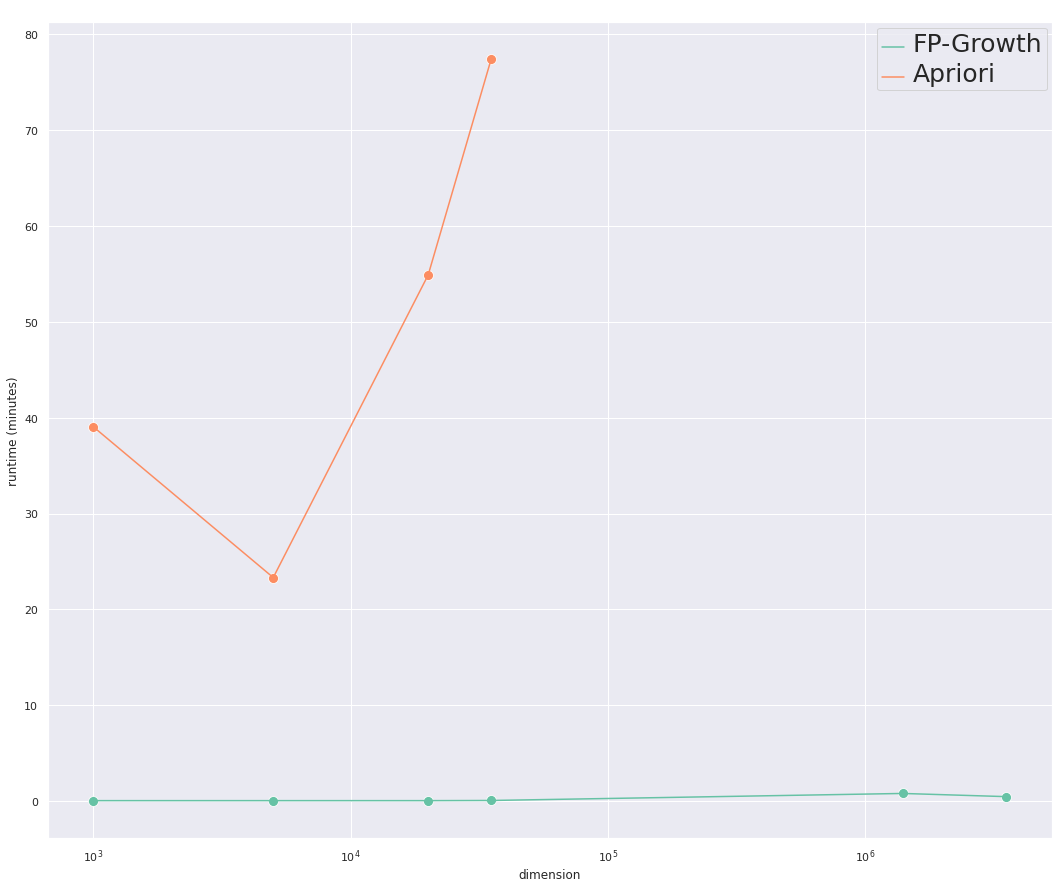

In [ ]:
sns.set(rc={"figure.figsize":(18,15)})
sns.set_theme(palette='Set2')

ax = sns.lineplot(x="dimension", y= "runtime (minutes)", data = data_FP, label='FP-Growth')
ax = sns.lineplot(x="dimension", y= "runtime (minutes)", data = data_apriori, label='Apriori')
ax = sns.scatterplot(x="dimension", y= "runtime (minutes)", marker = "o", s = 100, data = data_FP)
ax = sns.scatterplot(x="dimension", y= "runtime (minutes)", marker = "o", s = 100, data = data_apriori)

ax.set(title = " ", xlabel = "dimension", ylabel = "runtime (minutes)")
plt.setp(ax.get_legend().get_texts(), fontsize='25')
# set logscale to the x axis to better plot the result
ax.set(xscale="log")